# STEP 7

In [37]:
# Cell 2: Adaptive Retraining System Core Class

class AdaptiveRetrainingSystem:
    """
    Production-ready adaptive retraining system with drift detection.
    
    This system monitors model performance in production and triggers
    retraining when degradation is detected using multiple criteria:
    - Sustained performance degradation
    - Recent alert spikes
    - Statistical distribution drift
    - Time-based maintenance
    """
    
    def __init__(self, model_factory, baseline_metrics, 
                 alert_threshold=0.15, retrain_window=90, 
                 validation_window=30, max_history=180):
        """
        Parameters:
        -----------
        model_factory : callable
            Function that returns a fresh model instance
        baseline_metrics : dict
            Initial performance metrics from training
        alert_threshold : float
            Performance degradation threshold (15% default)
        retrain_window : int
            Days of recent data to use for retraining (90 default)
        validation_window : int
            Days to use for champion/challenger validation (30 default)
        max_history : int
            Maximum training history to keep (180 default)
        """
        self.model_factory = model_factory
        self.baseline_metrics = baseline_metrics
        self.alert_threshold = alert_threshold
        self.retrain_window = retrain_window
        self.validation_window = validation_window
        self.max_history = max_history
        
        # Initialize storage
        self.X_train_rolling = None
        self.y_train_rolling = None
        self.champion_model = None
        self.performance_log = []
        self.retrain_history = []
        self.baseline_feature_distribution = None
        
    def initialize(self, X_train, y_train, trained_model):
        """Initialize system with training data and champion model."""
        self.X_train_rolling = X_train.copy()
        self.y_train_rolling = y_train.copy()
        self.champion_model = trained_model
        
        # Store baseline feature distribution for drift detection
        numeric_cols = X_train.select_dtypes(include=[np.number]).columns
        self.baseline_feature_distribution = X_train[numeric_cols].iloc[:30].copy()
        
        print("✓ Adaptive Retraining System Initialized")
        print(f"  - Training samples: {len(X_train)}")
        print(f"  - Baseline RMSE: {self.baseline_metrics['RMSE_macro']:.4f}°C")
        print(f"  - Alert threshold: {self.alert_threshold*100}%")
        
    def predict_and_evaluate(self, X_new, y_true, date):
        """
        Make prediction and evaluate performance for a single day.
        
        Returns:
        --------
        dict : Performance metrics for this prediction
        """
        # Predict
        y_pred = self.champion_model.predict(X_new)
        
        # Compute metrics
        rmse = np.sqrt(np.mean((y_true.values - y_pred) ** 2))
        mae = np.mean(np.abs(y_true.values - y_pred))
        
        # Calculate degradation
        baseline_rmse = self.baseline_metrics['RMSE_macro']
        degradation = (rmse - baseline_rmse) / baseline_rmse
        
        # Check if alert should be triggered
        alert = degradation > self.alert_threshold
        
        # Log performance
        log_entry = {
            'date': date,
            'rmse': rmse,
            'mae': mae,
            'degradation': degradation,
            'alert': alert
        }
        self.performance_log.append(log_entry)
        
        if alert:
            print(f"⚠ ALERT on {date}: RMSE={rmse:.4f}°C (degradation: {degradation*100:.1f}%)")
        
        return log_entry
    
    def check_retrain_triggers(self):
        """
        Check multiple criteria to decide if retraining is needed.
        
        Returns:
        --------
        bool, list : Whether to retrain and reasons
        """
        if len(self.performance_log) < 30:
            return False, []
        
        reasons = []
        
        # Trigger 1: Sustained degradation over 30 days
        recent_30 = self.performance_log[-30:]
        avg_degradation = np.mean([log['degradation'] for log in recent_30])
        if avg_degradation > self.alert_threshold:
            reasons.append(f"Sustained degradation: {avg_degradation*100:.1f}%")
        
        # Trigger 2: High alert frequency in recent week
        recent_7 = self.performance_log[-7:]
        alert_rate = sum([log['alert'] for log in recent_7]) / len(recent_7)
        if alert_rate >= 0.7:  # 5+ out of 7 days
            reasons.append(f"Recent alert spike: {alert_rate*100:.0f}%")
        
        # Trigger 3: Distribution drift detection
        if self.X_train_rolling is not None and len(self.X_train_rolling) >= 60:
            drift_detected, n_drifted = self._detect_distribution_drift()
            if drift_detected:
                reasons.append(f"Distribution drift ({n_drifted} features)")
        
        # Trigger 4: Time-based maintenance (90 days since last retrain)
        if self.retrain_history:
            days_since_retrain = len(self.performance_log) - self.retrain_history[-1]['day_index']
            if days_since_retrain >= 90:
                reasons.append(f"Scheduled maintenance ({days_since_retrain} days)")
        elif len(self.performance_log) >= 90:
            reasons.append("Initial scheduled maintenance (90 days)")
        
        should_retrain = len(reasons) > 0
        return should_retrain, reasons
    
    def _detect_distribution_drift(self):
        """
        Use Kolmogorov-Smirnov test to detect feature distribution drift.
        
        Returns:
        --------
        bool, int : Whether drift detected and number of drifted features
        """
        numeric_cols = self.X_train_rolling.select_dtypes(include=[np.number]).columns
        
        # Compare baseline distribution with recent distribution
        recent_data = self.X_train_rolling[numeric_cols].iloc[-30:]
        baseline_data = self.baseline_feature_distribution
        
        drifted_features = 0
        for col in numeric_cols:
            if col in baseline_data.columns:
                stat, p_value = ks_2samp(baseline_data[col].dropna(), 
                                         recent_data[col].dropna())
                if p_value < 0.05:  # Significant drift detected
                    drifted_features += 1
        
        # Trigger if 3+ features have drifted
        return drifted_features >= 3, drifted_features
    
    def retrain_model(self, current_day_index):
        """
        Retrain model using champion/challenger approach.
        
        Returns:
        --------
        bool : Whether new model was adopted
        """
        print(f"\n{'='*80}")
        print(f"🔄 RETRAINING TRIGGERED on day {current_day_index}")
        print(f"{'='*80}")
        
        # Use recent data for training
        train_end = len(self.X_train_rolling)
        train_start = max(0, train_end - self.retrain_window)
        
        X_retrain = self.X_train_rolling.iloc[train_start:train_end]
        y_retrain = self.y_train_rolling.iloc[train_start:train_end]
        
        print(f"Training challenger on {len(X_retrain)} recent samples...")
        
        # Train challenger model
        challenger_model = self.model_factory()
        challenger_model.fit(X_retrain, y_retrain)
        
        # Validate both models on holdout
        val_end = train_start
        val_start = max(0, val_end - self.validation_window)
        
        if val_start >= val_end:
            print("⚠ Not enough data for validation, adopting challenger")
            self.champion_model = challenger_model
            self._update_baseline_metrics(X_retrain, y_retrain)
            return True
        
        X_val = self.X_train_rolling.iloc[val_start:val_end]
        y_val = self.y_train_rolling.iloc[val_start:val_end]
        
        # Compare champion vs challenger
        champion_pred = self.champion_model.predict(X_val)
        challenger_pred = challenger_model.predict(X_val)
        
        champion_rmse = np.sqrt(np.mean((y_val.values - champion_pred) ** 2))
        challenger_rmse = np.sqrt(np.mean((y_val.values - challenger_pred) ** 2))
        
        print(f"\nValidation Results:")
        print(f"  Champion RMSE:   {champion_rmse:.4f}°C")
        print(f"  Challenger RMSE: {challenger_rmse:.4f}°C")
        
        # Decision: adopt if challenger is better
        if challenger_rmse < champion_rmse:
            improvement = (champion_rmse - challenger_rmse) / champion_rmse * 100
            print(f"✓ Challenger ADOPTED (improved by {improvement:.2f}%)")
            
            self.champion_model = challenger_model
            self._update_baseline_metrics(X_retrain, y_retrain)
            
            self.retrain_history.append({
                'day_index': current_day_index,
                'adopted': True,
                'champion_rmse': champion_rmse,
                'challenger_rmse': challenger_rmse,
                'improvement': improvement
            })
            return True
        else:
            degradation = (challenger_rmse - champion_rmse) / champion_rmse * 100
            print(f"✗ Challenger REJECTED (worse by {degradation:.2f}%)")
            
            self.retrain_history.append({
                'day_index': current_day_index,
                'adopted': False,
                'champion_rmse': champion_rmse,
                'challenger_rmse': challenger_rmse,
                'improvement': -degradation
            })
            return False
    
    def _update_baseline_metrics(self, X_train, y_train):
        """Update baseline metrics after adopting new champion."""
        y_pred = self.champion_model.predict(X_train)
        new_rmse = np.sqrt(np.mean((y_train.values - y_pred) ** 2))
        new_mae = np.mean(np.abs(y_train.values - y_pred))
        
        self.baseline_metrics['RMSE_macro'] = new_rmse
        self.baseline_metrics['MAE_macro'] = new_mae
        
        print(f"Updated baseline RMSE: {new_rmse:.4f}°C")
    
    def add_training_sample(self, X_new, y_new):
        """Add new sample to rolling training window."""
        self.X_train_rolling = pd.concat([self.X_train_rolling, X_new], ignore_index=True)
        self.y_train_rolling = pd.concat([self.y_train_rolling, y_new], ignore_index=True)
        
        # Keep only recent history
        if len(self.X_train_rolling) > self.max_history:
            self.X_train_rolling = self.X_train_rolling.iloc[-self.max_history:]
            self.y_train_rolling = self.y_train_rolling.iloc[-self.max_history:]
    
    def generate_report(self):
        """Generate comprehensive monitoring report."""
        print(f"\n{'='*80}")
        print("📊 ADAPTIVE RETRAINING SYSTEM REPORT")
        print(f"{'='*80}\n")
        
        df_log = pd.DataFrame(self.performance_log)
        
        # Overall statistics
        print("Overall Performance:")
        print(f"  Total predictions: {len(df_log)}")
        print(f"  Average RMSE: {df_log['rmse'].mean():.4f}°C")
        print(f"  Average degradation: {df_log['degradation'].mean()*100:.2f}%")
        print(f"  Alert rate: {df_log['alert'].mean()*100:.1f}%")
        
        # Retraining statistics
        print(f"\nRetraining Events:")
        print(f"  Total retrains: {len(self.retrain_history)}")
        if self.retrain_history:
            adopted = sum([e['adopted'] for e in self.retrain_history])
            print(f"  Adopted: {adopted}")
            print(f"  Rejected: {len(self.retrain_history) - adopted}")
            
            if adopted > 0:
                avg_improvement = np.mean([e['improvement'] for e in self.retrain_history 
                                          if e['adopted']])
                print(f"  Average improvement (adopted): {avg_improvement:.2f}%")

print("✓ AdaptiveRetrainingSystem class defined")

✓ AdaptiveRetrainingSystem class defined


In [47]:
# Cell 3: Add visualization method to AdaptiveRetrainingSystem (FIXED)

def visualize_performance_drift(self, save_path=None):
    """Generate comprehensive performance monitoring dashboard matching notebook style."""
    if len(self.performance_log) < 10:
        print("Not enough data for visualization")
        return
    
    df_log = pd.DataFrame(self.performance_log)
    
    # Create figure with notebook style
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.patch.set_facecolor('white')
    
    # Plot 1: RMSE over time
    axes[0, 0].plot(df_log['date'], df_log['rmse'], linewidth=2, 
                   color='steelblue', label='Daily RMSE')
    axes[0, 0].axhline(self.baseline_metrics['RMSE_macro'], 
                      color='green', linestyle='--', label='Baseline RMSE', linewidth=2)
    
    # Mark retraining events
    retrain_marked = False
    for event in self.retrain_history:
        if event['adopted']:
            event_date = df_log.iloc[event['day_index']]['date']
            if not retrain_marked:
                axes[0, 0].axvline(event_date, color='red', linestyle=':', 
                                  alpha=0.7, linewidth=2, label='Retrain Event')
                retrain_marked = True
            else:
                axes[0, 0].axvline(event_date, color='red', linestyle=':', 
                                  alpha=0.7, linewidth=2)
    
    axes[0, 0].set_xlabel('Date', fontsize=11)
    axes[0, 0].set_ylabel('RMSE (°C)', fontsize=11)
    axes[0, 0].set_title('Model Performance Over Time', fontsize=12, fontweight='bold')
    axes[0, 0].legend(loc='best')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Performance degradation
    axes[0, 1].plot(df_log['date'], df_log['degradation'] * 100, 
                   linewidth=2, color='darkorange', label='Degradation')
    axes[0, 1].axhline(self.alert_threshold * 100, 
                      color='red', linestyle='--', label='Alert Threshold', linewidth=2)
    axes[0, 1].fill_between(df_log['date'], 0, self.alert_threshold * 100, 
                            alpha=0.2, color='green', label='Safe Zone')
    
    max_degradation = max(df_log['degradation'].max() * 100, self.alert_threshold * 100 + 10)
    axes[0, 1].fill_between(df_log['date'], self.alert_threshold * 100, 
                            max_degradation, 
                            alpha=0.2, color='red', label='Alert Zone')
    
    axes[0, 1].set_xlabel('Date', fontsize=11)
    axes[0, 1].set_ylabel('Degradation (%)', fontsize=11)
    axes[0, 1].set_title('Performance Degradation', fontsize=12, fontweight='bold')
    axes[0, 1].legend(loc='best')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Retraining events summary (FIXED - only show summary statistics)
    if self.retrain_history:
        # Calculate summary statistics
        total_retrains = len(self.retrain_history)
        adopted = sum([e['adopted'] for e in self.retrain_history])
        rejected = total_retrains - adopted
        
        if adopted > 0:
            avg_improvement = np.mean([e['improvement'] for e in self.retrain_history if e['adopted']])
        else:
            avg_improvement = 0
        
        # Create bar chart with summary
        categories = ['Total\nRetrains', 'Adopted', 'Rejected']
        values = [total_retrains, adopted, rejected]
        colors_bar = ['steelblue', 'green', 'gray']
        
        bars = axes[1, 0].bar(categories, values, color=colors_bar, alpha=0.7, 
                              edgecolor='black', linewidth=1.5)
        axes[1, 0].set_ylabel('Count', fontsize=11)
        axes[1, 0].set_title(f'Retraining Summary\n(Avg Improvement: {avg_improvement:.2f}%)', 
                            fontsize=12, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                           f'{int(val)}',
                           ha='center', va='bottom', fontsize=11, fontweight='bold')
    else:
        axes[1, 0].text(0.5, 0.5, 'No retraining events yet', 
                       ha='center', va='center', transform=axes[1, 0].transAxes, 
                       fontsize=12, color='gray')
        axes[1, 0].set_title('Retraining Summary', fontsize=12, fontweight='bold')
        axes[1, 0].set_xticks([])
        axes[1, 0].set_yticks([])
    
    # Plot 4: Rolling alert rate
    window_size = 30
    if len(df_log) >= window_size:
        df_log['alert_rate'] = df_log['alert'].rolling(window_size).mean() * 100
        axes[1, 1].plot(df_log['date'], df_log['alert_rate'], 
                       linewidth=2, color='crimson', label='Alert Rate')
        axes[1, 1].axhline(30, color='orange', linestyle='--', 
                          label='30% Threshold', linewidth=2)
        axes[1, 1].set_xlabel('Date', fontsize=11)
        axes[1, 1].set_ylabel('Alert Rate (%)', fontsize=11)
        axes[1, 1].set_title(f'{window_size}-Day Rolling Alert Rate', 
                            fontsize=12, fontweight='bold')
        axes[1, 1].legend(loc='best')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_ylim([0, 100])
    else:
        axes[1, 1].text(0.5, 0.5, f'Need {window_size}+ days for rolling alert rate', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, 
                       fontsize=10, color='gray')
        axes[1, 1].set_title(f'{window_size}-Day Rolling Alert Rate', 
                            fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Dashboard saved to {save_path}")
    
    plt.show()

# Attach method to class
AdaptiveRetrainingSystem.visualize_performance_drift = visualize_performance_drift

print("✓ Visualization method added (FIXED)")

✓ Visualization method added (FIXED)


In [48]:
# Cell 4: Model Factory Functions

def create_model_factory():
    """
    Factory function that returns a fresh BayesianRidge model.
    This is for SINGLE MODEL simulation.
    """
    from sklearn.linear_model import BayesianRidge
    from sklearn.multioutput import MultiOutputRegressor
    
    def factory():
        # Return the FULL pipeline (preprocessor + model)
        estimator = MultiOutputRegressor(BayesianRidge())
        return make_pipeline(estimator)
    
    return factory


class EnsembleModel:
    """
    Wrapper class for ensemble that ensures both models retrain together.
    This treats the ensemble as a single retrainable unit.
    """
    
    def __init__(self, preprocessor):
        """Initialize with preprocessor."""
        from sklearn.linear_model import BayesianRidge
        from sklearn.ensemble import HistGradientBoostingRegressor
        from sklearn.multioutput import MultiOutputRegressor
        
        self.preprocessor = preprocessor
        
        # Define both base models
        self.bayesian_model = MultiOutputRegressor(BayesianRidge())
        
        # Use the BEST tuned HGB parameters from earlier
        best_hgb_params = {
            'learning_rate': 0.02014148621347681,
            'max_depth': 3,
            'max_iter': 493,
            'min_samples_leaf': 25,
            'l2_regularization': 9.852173472173725e-06
        }
        self.hgb_model = MultiOutputRegressor(
            HistGradientBoostingRegressor(random_state=RANDOM_STATE, **best_hgb_params)
        )
        
        self.models = [self.bayesian_model, self.hgb_model]
    
    def fit(self, X, y):
        """Fit both models in the ensemble."""
        # Preprocess
        X_processed = self.preprocessor.fit_transform(X)
        X_processed = to_dense(X_processed)
        
        # Train both models
        for model in self.models:
            model.fit(X_processed, y)
        
        return self
    
    def predict(self, X):
        """Average predictions from both models."""
        X_processed = self.preprocessor.transform(X)
        X_processed = to_dense(X_processed)
        
        predictions = []
        for model in self.models:
            pred = model.predict(X_processed)
            predictions.append(pred)
        
        # Simple average
        return np.mean(predictions, axis=0)


def create_ensemble_model_factory():
    """
    Factory function that returns a fresh Ensemble model.
    This is for ENSEMBLE simulation.
    """
    def factory():
        preprocessor = build_preprocessor()
        return EnsembleModel(preprocessor)
    
    return factory

print("✓ Model factory functions defined")

✓ Model factory functions defined


In [49]:
# Cell 5: Production Simulation Runner

def run_production_simulation(X_train, y_train, X_test, y_test, test_dates,
                              model_factory, baseline_metrics, 
                              simulation_name="Simulation"):
    """
    Simulate production deployment with daily predictions and adaptive retraining.
    
    Parameters:
    -----------
    X_train, y_train : DataFrame
        Initial training data
    X_test, y_test : DataFrame
        Test data (simulates production stream)
    test_dates : Series
        Dates for test samples
    model_factory : callable
        Function returning fresh model instance
    baseline_metrics : dict
        Initial performance metrics
    simulation_name : str
        Name for this simulation run
        
    Returns:
    --------
    AdaptiveRetrainingSystem : Trained system with performance logs
    """
    print(f"\n{'='*80}")
    print(f"🚀 STARTING PRODUCTION SIMULATION: {simulation_name}")
    print(f"{'='*80}\n")
    
    # Initialize system
    system = AdaptiveRetrainingSystem(
        model_factory=model_factory,
        baseline_metrics=baseline_metrics.copy(),
        alert_threshold=0.15,  # 15% degradation triggers alert
        retrain_window=90,     # Use 90 days for retraining
        validation_window=30,  # 30 days for validation
        max_history=180        # Keep 180 days of history
    )
    
    # Train initial champion model
    print("Training initial champion model...")
    champion = model_factory()
    champion.fit(X_train, y_train)
    
    system.initialize(X_train, y_train, champion)
    
    # Simulate daily production
    print(f"\nSimulating {len(X_test)} days of production...")
    
    for i in range(len(X_test)):
        # Get current day's data
        X_current = X_test.iloc[[i]]
        y_current = y_test.iloc[[i]]
        current_date = test_dates.iloc[i]
        
        # Predict and evaluate
        system.predict_and_evaluate(X_current, y_current, current_date)
        
        # Add to rolling training window
        system.add_training_sample(X_current, y_current)
        
        # Check if retraining is needed
        should_retrain, reasons = system.check_retrain_triggers()
        
        if should_retrain:
            print(f"\nReasons: {', '.join(reasons)}")
            system.retrain_model(current_day_index=i)
    
    # Generate final report
    system.generate_report()
    
    return system

print("✓ Simulation runner function defined")

✓ Simulation runner function defined


In [50]:
# Cell 6: Single vs Ensemble Comparison Function

def compare_single_vs_ensemble(system_single, system_ensemble):
    """
    Compare performance between single model and ensemble.
    
    Parameters:
    -----------
    system_single : AdaptiveRetrainingSystem
        System using single BayesianRidge model
    system_ensemble : AdaptiveRetrainingSystem
        System using ensemble (BayesianRidge + HGB)
    """
    print(f"\n{'='*80}")
    print("📊 SINGLE MODEL vs ENSEMBLE COMPARISON")
    print(f"{'='*80}\n")
    
    df_single = pd.DataFrame(system_single.performance_log)
    df_ensemble = pd.DataFrame(system_ensemble.performance_log)
    
    # Calculate statistics
    comparison = {
        'Metric': ['Average RMSE', 'Average MAE', 'Alert Rate (%)', 
                   'Total Retrains', 'Retrains Adopted'],
        'Single Model': [
            df_single['rmse'].mean(),
            df_single['mae'].mean(),
            df_single['alert'].mean() * 100,
            len(system_single.retrain_history),
            sum([e['adopted'] for e in system_single.retrain_history]) if system_single.retrain_history else 0
        ],
        'Ensemble': [
            df_ensemble['rmse'].mean(),
            df_ensemble['mae'].mean(),
            df_ensemble['alert'].mean() * 100,
            len(system_ensemble.retrain_history),
            sum([e['adopted'] for e in system_ensemble.retrain_history]) if system_ensemble.retrain_history else 0
        ]
    }
    
    df_comparison = pd.DataFrame(comparison)
    df_comparison['Difference'] = df_comparison['Ensemble'] - df_comparison['Single Model']
    df_comparison['Improvement (%)'] = (
        (df_comparison['Single Model'] - df_comparison['Ensemble']) / 
        df_comparison['Single Model'] * 100
    )
    
    display(df_comparison.style.background_gradient(cmap='RdYlGn', subset=['Improvement (%)']))
    
    # Visualization matching notebook style
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.patch.set_facecolor('white')
    
    # RMSE comparison over time
    axes[0].plot(df_single['date'], df_single['rmse'], 
                label='Single Model', linewidth=2, alpha=0.8, color='steelblue')
    axes[0].plot(df_ensemble['date'], df_ensemble['rmse'], 
                label='Ensemble', linewidth=2, alpha=0.8, color='coral')
    axes[0].set_xlabel('Date', fontsize=11)
    axes[0].set_ylabel('RMSE (°C)', fontsize=11)
    axes[0].set_title('RMSE Over Time: Single vs Ensemble', fontsize=12, fontweight='bold')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    
    # Alert rate comparison
    window = 30
    if len(df_single) >= window:
        df_single['alert_rate'] = df_single['alert'].rolling(window).mean() * 100
        df_ensemble['alert_rate'] = df_ensemble['alert'].rolling(window).mean() * 100
        
        axes[1].plot(df_single['date'], df_single['alert_rate'], 
                    label='Single Model', linewidth=2, alpha=0.8, color='steelblue')
        axes[1].plot(df_ensemble['date'], df_ensemble['alert_rate'], 
                    label='Ensemble', linewidth=2, alpha=0.8, color='coral')
        axes[1].set_xlabel('Date', fontsize=11)
        axes[1].set_ylabel('Alert Rate (%)', fontsize=11)
        axes[1].set_title(f'{window}-Day Rolling Alert Rate', fontsize=12, fontweight='bold')
        axes[1].legend(loc='best')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Decision recommendation
    print(f"\n{'='*80}")
    print("💡 RECOMMENDATION:")
    
    rmse_improvement = df_comparison[df_comparison['Metric'] == 'Average RMSE']['Improvement (%)'].values[0]
    alert_reduction = df_comparison[df_comparison['Metric'] == 'Alert Rate (%)']['Difference'].values[0]
    
    if rmse_improvement > 5 and alert_reduction < -5:
        print("✓ DEPLOY ENSEMBLE")
        print(f"  Significant improvement: RMSE {rmse_improvement:.1f}% better")
        print(f"  Alert rate reduced by {abs(alert_reduction):.1f}%")
        print("  The ensemble is worth the 2x training cost.")
    elif rmse_improvement > 2:
        print("~ CONSIDER ENSEMBLE")
        print(f"  Moderate improvement: RMSE {rmse_improvement:.1f}% better")
        print("  Evaluate if benefit justifies 2x training cost.")
    else:
        print("✗ USE SINGLE MODEL")
        print(f"  Minimal improvement: RMSE {rmse_improvement:.1f}% better")
        print("  Not worth the additional computational cost.")
    
    print(f"{'='*80}\n")

print("✓ Comparison function defined")

✓ Comparison function defined


In [51]:
# Cell 7: Run Single Model Simulation (BayesianRidge)

print("\n" + "="*80)
print("🎯 ADAPTIVE RETRAINING SYSTEM - PRODUCTION SIMULATION")
print("="*80)

print("\n1️⃣  Running simulation with SINGLE MODEL (BayesianRidge)...")
adaptive_system = run_production_simulation(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    test_dates=test_dates,
    model_factory=create_model_factory(),
    baseline_metrics=model_results['BayesianRidge']['test_metrics'],
    simulation_name="Single Model (BayesianRidge)"
)


🎯 ADAPTIVE RETRAINING SYSTEM - PRODUCTION SIMULATION

1️⃣  Running simulation with SINGLE MODEL (BayesianRidge)...

🚀 STARTING PRODUCTION SIMULATION: Single Model (BayesianRidge)

Training initial champion model...
✓ Adaptive Retraining System Initialized
  - Training samples: 3308
  - Baseline RMSE: 0.9777°C
  - Alert threshold: 15.0%

Simulating 584 days of production...

Reasons: Distribution drift (111 features)

🔄 RETRAINING TRIGGERED on day 29
Training challenger on 90 recent samples...

Validation Results:
  Champion RMSE:   0.9296°C
  Challenger RMSE: 0.9350°C
✗ Challenger REJECTED (worse by 0.59%)

Reasons: Distribution drift (110 features)

🔄 RETRAINING TRIGGERED on day 30
Training challenger on 90 recent samples...

Validation Results:
  Champion RMSE:   0.9299°C
  Challenger RMSE: 0.9313°C
✗ Challenger REJECTED (worse by 0.15%)

Reasons: Distribution drift (109 features)

🔄 RETRAINING TRIGGERED on day 31
Training challenger on 90 recent samples...

Validation Results:
  Ch

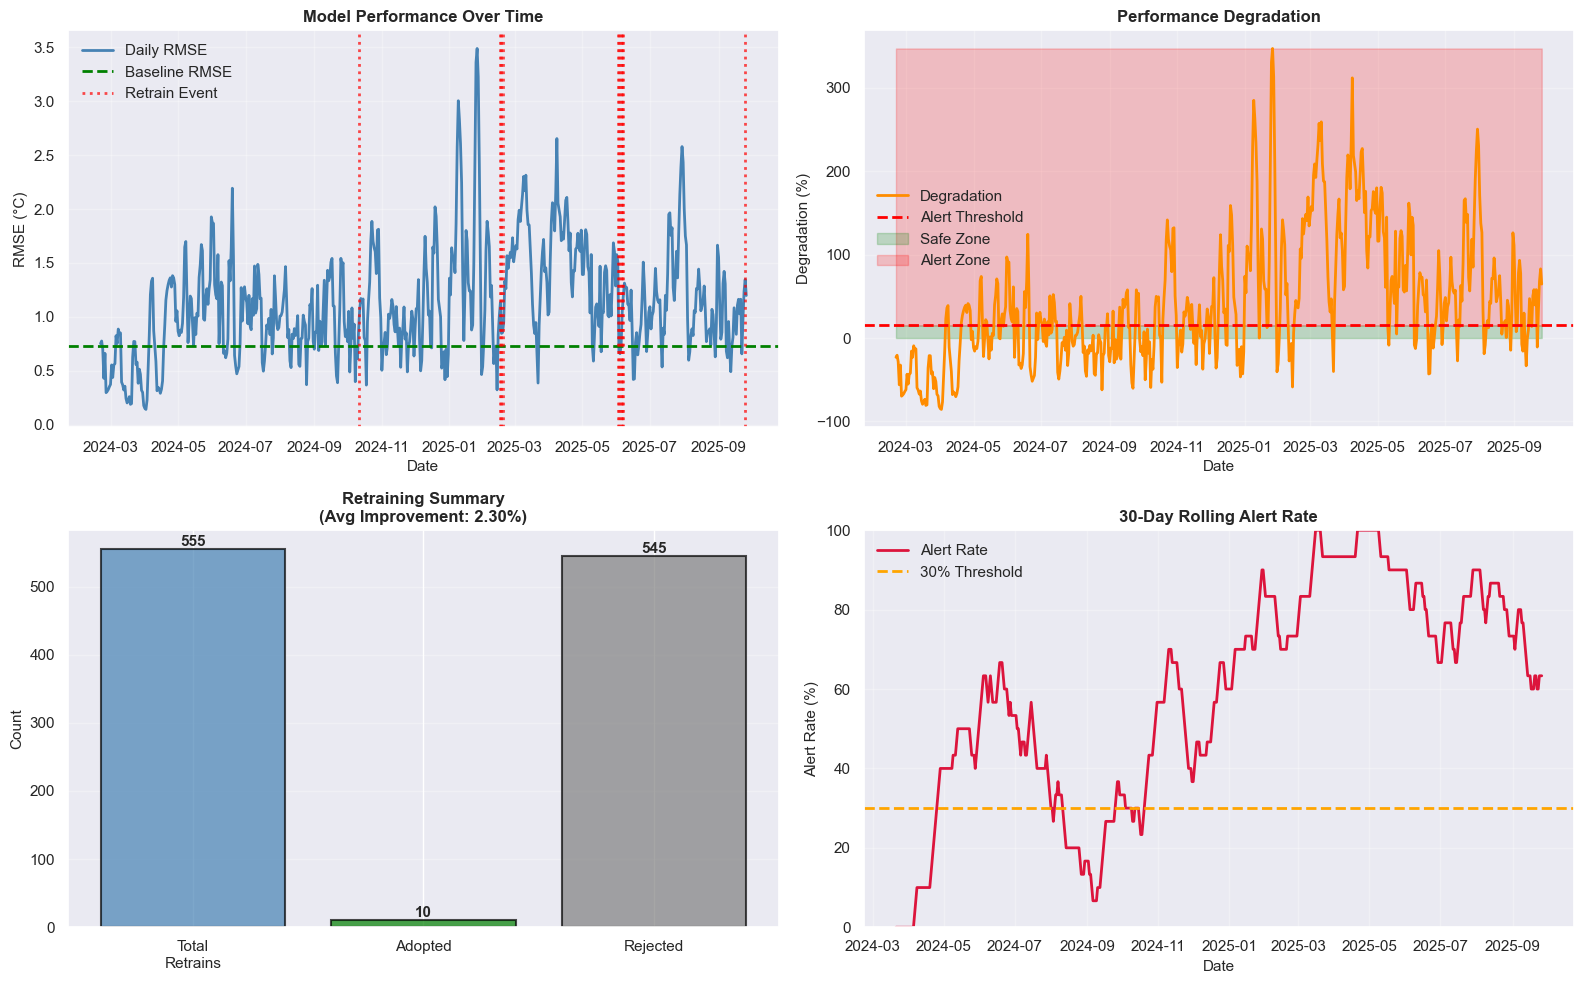

In [53]:
# Cell 8: Visualize Single Model Performance

adaptive_system.visualize_performance_drift()

In [54]:
# Cell 9: Run Ensemble Simulation (BayesianRidge + HGB)

print("\n2️⃣  Running simulation with ENSEMBLE (BayesianRidge + HGB)...")
adaptive_system_ensemble = run_production_simulation(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    test_dates=test_dates,
    model_factory=create_ensemble_model_factory(),
    baseline_metrics=model_results['BayesianRidge_HGB_Ensemble']['test_metrics'],
    simulation_name="Ensemble (BayesianRidge + HGB)"
)


2️⃣  Running simulation with ENSEMBLE (BayesianRidge + HGB)...

🚀 STARTING PRODUCTION SIMULATION: Ensemble (BayesianRidge + HGB)

Training initial champion model...
✓ Adaptive Retraining System Initialized
  - Training samples: 3308
  - Baseline RMSE: 0.9585°C
  - Alert threshold: 15.0%

Simulating 584 days of production...

Reasons: Distribution drift (111 features)

🔄 RETRAINING TRIGGERED on day 29
Training challenger on 90 recent samples...

Validation Results:
  Champion RMSE:   0.7913°C
  Challenger RMSE: 0.8633°C
✗ Challenger REJECTED (worse by 9.10%)

Reasons: Distribution drift (110 features)

🔄 RETRAINING TRIGGERED on day 30
Training challenger on 90 recent samples...

Validation Results:
  Champion RMSE:   0.7898°C
  Challenger RMSE: 0.8464°C
✗ Challenger REJECTED (worse by 7.17%)

Reasons: Distribution drift (109 features)

🔄 RETRAINING TRIGGERED on day 31
Training challenger on 90 recent samples...

Validation Results:
  Champion RMSE:   0.7927°C
  Challenger RMSE: 0.8586°

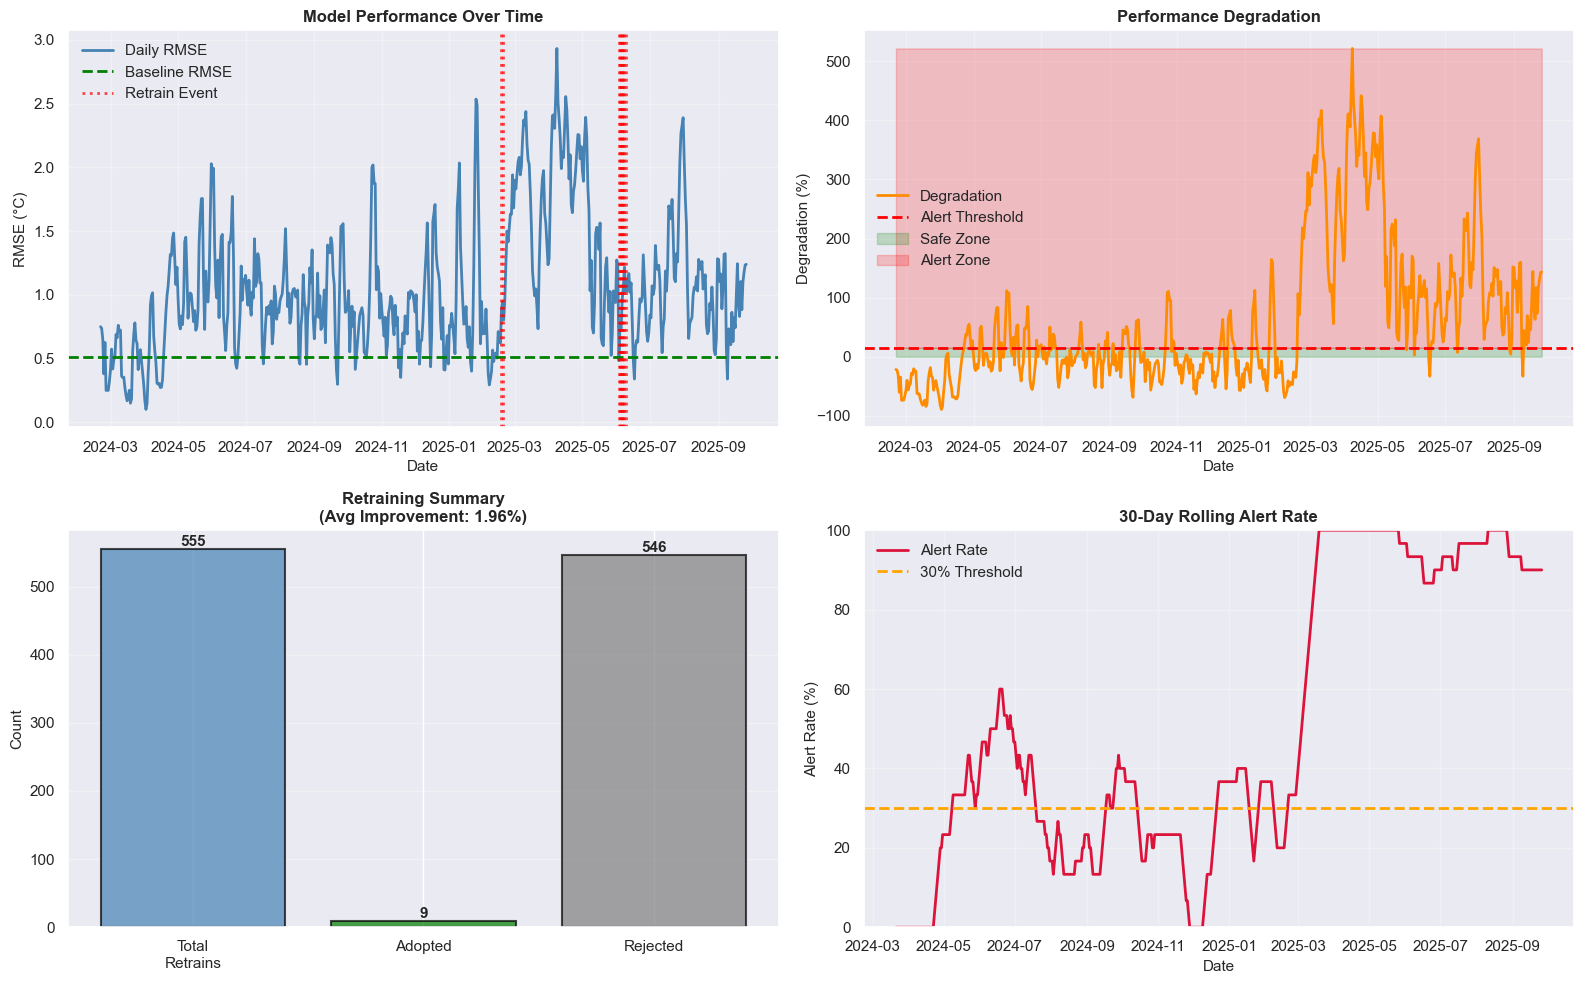

In [55]:
# Cell 10: Visualize Ensemble Performance

adaptive_system_ensemble.visualize_performance_drift()


📊 SINGLE MODEL vs ENSEMBLE COMPARISON



,Metric,Single Model,Ensemble,Difference,Improvement (%)
0,Average RMSE,1.124780,1.060162,-0.064618,5.744955
1,Average MAE,0.991567,0.937755,-0.053813,5.427045
2,Alert Rate (%),58.047945,51.198630,-6.849315,11.799410
3,Total Retrains,555.000000,555.000000,0.000000,0.000000
4,Retrains Adopted,10.000000,9.000000,-1.000000,10.000000


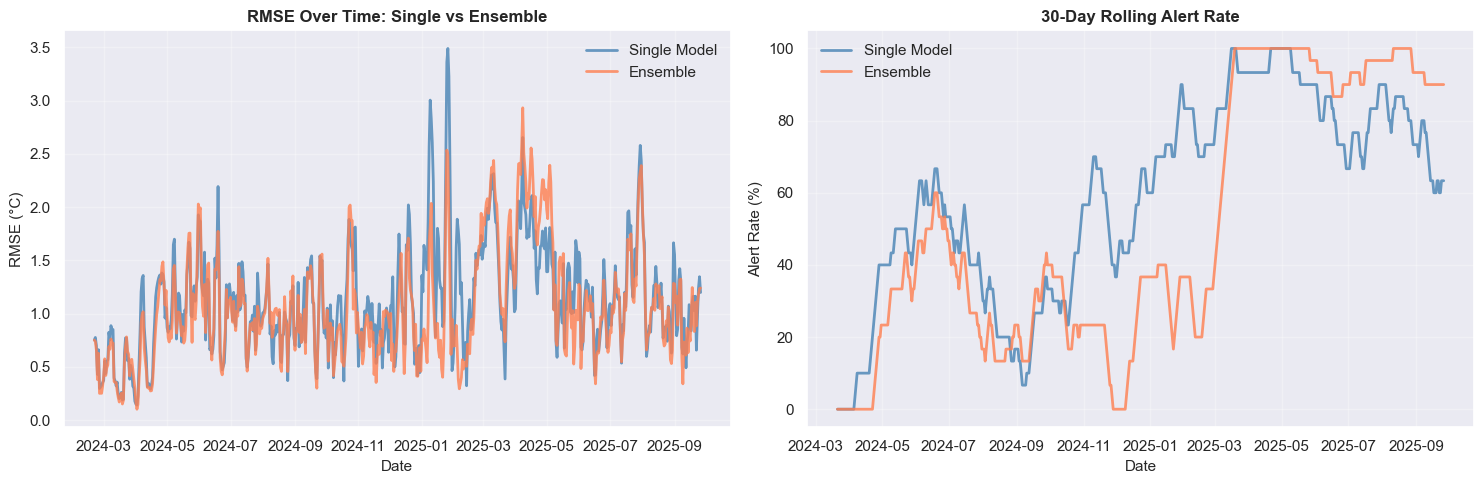


💡 RECOMMENDATION:
✓ DEPLOY ENSEMBLE
  Significant improvement: RMSE 5.7% better
  Alert rate reduced by 6.8%
  The ensemble is worth the 2x training cost.


✅ Production simulation complete!


In [56]:
# Cell 11: Compare Single Model vs Ensemble

compare_single_vs_ensemble(adaptive_system, adaptive_system_ensemble)

print("\n✅ Production simulation complete!")